In [28]:
!pip install treelite treelite_runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.8/922.8 kB 7.3 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.7/198.7 kB 6.0 MB/s eta 0:00:00


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np, gc
import tensorflow as tf
import gc
import joblib
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from IPython.display import display
from ipywidgets import FileUpload


upload = FileUpload()
display(upload)


2025-08-26 17:59:33.057222: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 17:59:33.163496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756223973.210913 1840067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756223973.223996 1840067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756223973.317643 1840067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

FileUpload(value=(), description='Upload')

In [2]:
df_edge = pd.read_csv("Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")
df_edge.head()

/tmp/ipykernel_1840067/2719784295.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_edge = pd.read_csv("Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")


,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [3]:
drop_cols = [
    "frame.time", "ip.src_host", "ip.dst_host", 
    "http.file_data", "http.request.uri.query", "http.request.method",
    "http.referer", "http.request.full_uri", "http.request.version",
    "dns.qry.name", "mqtt.protoname", "mqtt.topic"
]

df_edge_clean = df_edge.drop(columns=drop_cols, errors="ignore")


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, y_true, y_pred, labels=None):
    print(f"{name} — Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1 (weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1 (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }


In [5]:
# ==== Multiclass baseline (BEFORE any balancing) ====
#import numpy as np, pandas as pd, gc
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.pipeline import Pipeline
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#import tensorflow as tf

# If these already exist above, this block will just reuse them.
def ensure_labels_and_split(df, X=None, y=None, class_names=None, test_size=0.2, seed=42):
    if X is None or y is None or class_names is None:
        # X: keep the numeric features you used earlier (already cleaned)
        # If you already have X, y, class_names defined, skip this.
        # Here I assume df_edge_clean exists and has Attack_type.
        X = df_edge_clean.drop(columns=['Attack_type'])
        y_str = df_edge_clean['Attack_type'].astype(str).values
        le = LabelEncoder()
        y = le.fit_transform(y_str)
        class_names = le.classes_
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=seed
    )
    return X, y, class_names, X_train, X_test, y_train, y_test

# evaluate_model must already be defined in your notebook (you showed it earlier).
# If not, reuse your earlier evaluate_model with target_names=labels.

# Ensure labels/splits exist
X, y, class_names, X_train, X_test, y_train, y_test = ensure_labels_and_split(
    df_edge_clean, X if 'X' in globals() else None,
    y if 'y' in globals() else None,
    class_names if 'class_names' in globals() else None
)


In [6]:
# Float32 views to reduce RAM
#X_train32 = np.asarray(X_train, dtype=np.float32)
#X_test32  = np.asarray(X_test,  dtype=np.float32)
#X_train32 = np.nan_to_num(X_train32, nan=0.0, posinf=0.0, neginf=0.0)
#X_test32  = np.nan_to_num(X_test32,  nan=0.0, posinf=0.0, neginf=0.0)

num_classes = len(class_names)

# GPU check (for XGB and CNN)
# GPU flag + safe memory-growth (won’t crash if already initialized)
#import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
use_gpu = len(gpus) > 0
if use_gpu:
    try:
        for gpu in gpus:
            # only try to set if not already enabled
            if not tf.config.experimental.get_memory_growth(gpu):
                tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        # Runtime already initialized; it's fine, continue
        pass

print("GPU available:", use_gpu, "| GPUs:", gpus)

GPU available: True | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:

# class weights + per-sample weights
classes = np.unique(y_train)
cw_vals = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {c: w for c, w in zip(classes, cw_vals)}
sample_weight = np.array([class_weight_dict[c] for c in y_train])

results_tab = []
n_jobs = -1
use_gpu = True  # or your detected flag


In [ ]:
'''
# XGB
xgb_cw_42f = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    device='cuda' if use_gpu else 'cpu',
    n_jobs=n_jobs,
    random_state=42
)
xgb_cw_42f.fit(X_train32, y_train, sample_weight=sample_weight)
y_xgb = xgb_cw_42f.predict(X_test32)
results_tab.append(evaluate_model("XGBoost (class-weighted" + (" GPU)" if use_gpu else " CPU)"),
                                  y_test, y_xgb, labels=class_names))
gc.collect()

joblib.dump(xgb_cw_42f, "xgb_cw_42f.pkl")
'''

In [8]:

y_str = df_edge_clean["Attack_type"].astype(str).values
# Avoid shadowing old vars
le = LabelEncoder()
y_clean = le.fit_transform(df_edge_clean["Attack_type"].astype(str))
class_names = le.classes_

X_clean = (
    df_edge_clean
    .drop(columns=["Attack_type", "Attack_label"], errors="ignore")
    .select_dtypes(include=[np.number])
    .fillna(0.0)
)



In [9]:
print("X shape:", X_clean.shape)
print("y shape:", y_str.shape)
print("Number of classes:", num_classes)
print("Classes:", class_names)


X shape: (2219201, 41)
y shape: (2219201,)
Number of classes: 15
Classes: ['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']


In [10]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
)


In [11]:
# --- Prep: float32 views of the CLEAN splits ---
import numpy as np
X_train_clean32 = np.nan_to_num(np.asarray(X_train_clean, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
X_test_clean32  = np.nan_to_num(np.asarray(X_test_clean,  dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)


/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:24:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [23:24:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [23:24:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to high

XGBoost (class-weighted GPU) — Classification Report:

                       precision    recall  f1-score   support

             Backdoor       0.99      0.94      0.97      4972
            DDoS_HTTP       0.75      0.92      0.83      9982
            DDoS_ICMP       1.00      1.00      1.00     23287
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.30      0.82      0.44       200
                 MITM       0.12      1.00      0.22       243
               Normal       1.00      0.98      0.99    323129
             Password       0.75      0.79      0.77     10031
        Port_Scanning       0.87      0.93      0.90      4513
           Ransomware       0.89      0.87      0.88      2185
        SQL_injection       0.86      0.84      0.85     10241
            Uploading       0.94      0.85      0.89      7527
Vulnerability_scanner       0.94      0.96      0.95     10022

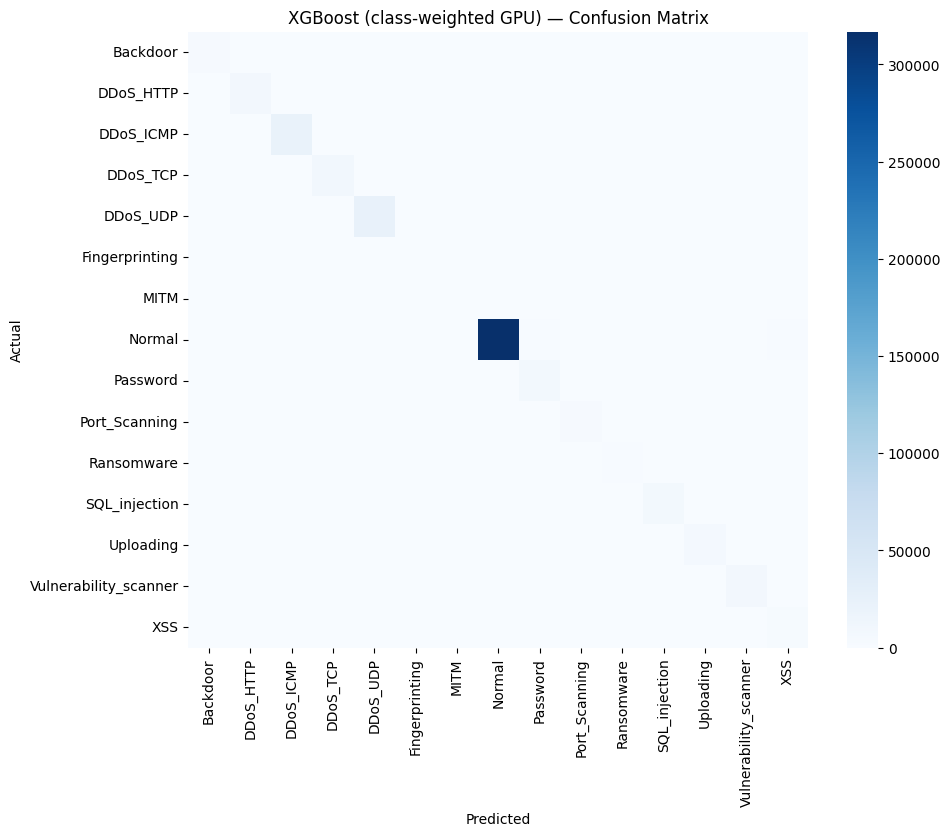

NameError: name 'clf' is not defined

In [12]:

# === Class weights + XGBoost training (CLEAN splits) ===

# Recompute balanced class weights from y_train_clean (avoid stale globals)
classes_unique = np.unique(y_train_clean)
cw = compute_class_weight(class_weight='balanced', classes=classes_unique, y=y_train_clean)
class_weight_dict = {int(c): float(w) for c, w in zip(classes_unique, cw)}

# Per-sample weights for XGBoost (labels assumed 0..K-1 from LabelEncoder)
class_weights_array = np.zeros(classes_unique.max() + 1, dtype=np.float32)
class_weights_array[classes_unique] = cw.astype(np.float32)
sample_weight_clean = class_weights_array[y_train_clean]

# Detect GPU (simple toggle; set to False if you want CPU)
try:
    import tensorflow as tf
    use_gpu = len(tf.config.list_physical_devices('GPU')) > 0
except Exception:
    use_gpu = False

# Build XGBoost model (GPU uses gpu_hist; CPU uses hist)
tree_method = 'gpu_hist' if use_gpu else 'hist'
xgb_cw_42f_LLf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    tree_method=tree_method,
    n_jobs=n_jobs,
    random_state=42
)

# Train (on CLEAN splits)
xgb_cw_42f_LLf.fit(
    X_train_clean32, y_train_clean,
    sample_weight=sample_weight_clean,
    eval_set=[(X_test_clean32, y_test_clean)],
    verbose=False
)

# Predict + evaluate (CLEAN test)
y_xgb_clean = xgb_cw_42f_LLf.predict(X_test_clean32)
results_tab.append(
    evaluate_model(
        "XGBoost (class-weighted" + (" GPU)" if use_gpu else " CPU)"),
        y_test_clean, y_xgb_clean, labels=class_names
    )
)

# Save the trained XGB model (correct object)
joblib.dump(xgb_cw_42f_LLf, "xgb_cw_42f_LLf.pkl")
gc.collect()


In [47]:
bst = joblib.load("xgb_cw_42f_LLf.pkl").get_booster()
bst.save_model("xgb_cw_42f_LLf.json")
print("Saved xgb_cw_42f_LLf.json")


Saved xgb_cw_42f_LLf.json


/tmp/ipykernel_33276/1416402355.py:2: UserWarning: [01:18:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.save_model("xgb_cw_42f_LLf.json")


In [14]:
import joblib
import numpy as np

# Load the saved model
clf_xgb = joblib.load("xgb_cw_42f_LLf.pkl")

# Pick index 33 from the test set
idx = 20

# Extract the row (make sure it's 2D for predict)
row = X_test_clean.iloc[[idx]]
true_label_encoded = y_test_clean[idx]

# Decode the true label name
true_label = class_names[true_label_encoded]

# Predict using the loaded model
pred_encoded = clf_xgb.predict(row)[0]
pred_label = class_names[pred_encoded]

# Optional: prediction probabilities
probs = clf_xgb.predict_proba(row)[0]
top_class = class_names[np.argmax(probs)]
top_conf  = np.max(probs)

print(f"\n🔎 Testing index {idx}")
print(f"Input features ({row.shape[1]}):\n{row.values.flatten()}\n")
print(f"✅ True label : {true_label}")
print(f"🤖 Predicted  : {pred_label} (encoded={pred_encoded})")
print(f"🔢 Top class probability: {top_conf:.4f}")



🔎 Testing index 20
Input features (41):
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 2.01604771e+08 2.72790000e+04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 5.48920000e+04 1.80000000e+01 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

✅ True label : Normal
🤖 Predicted  : Password (encoded=8)
🔢 Top class probability: 0.4797


In [15]:
row

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,...,mqtt.hdrflags,mqtt.len,mqtt.msg_decoded_as,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id
1258764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# --- Make C init lines for a given test index (e.g., 33) ---
vals = row.values.flatten().astype(np.float32)
cols = list(X_test_clean.columns)

# sanity: feature count must match what TL2cgen reports on-device
print(f"Features in row: {len(cols)}")
#print("First few (name=value):", list(zip(cols, vals))[:5], "...")

# 1) C assignments for union Entry buffer
#print("\n// --- paste into main.c to fill xbuf[i].fvalue ---")
#for i, (c, v) in enumerate(zip(cols, vals)):
    # %.10g prints compactly but still precise; add 'f' suffix for float literal
#    print(f"  xbuf[{i}].fvalue = {v:.10g}f;  // {c}")

# 2) Optional: C float array if you prefer a memcpy/loop
#print("\n// --- or use a float array then copy into xbuf ---")
arr = ", ".join(f"{v:.10g}f" for v in vals)
print(f"static const float TEST_{idx}[{len(vals)}] = {{ {arr} }};")

# 3) Quick check against your PC prediction (so board output can be compared)
pred = clf_xgb.predict(row)[0]
probs = clf_xgb.predict_proba(row)[0]
print(f"\nPC says: class_id={pred}  name={class_names[pred]}  p={probs[pred]:.4f}")


Features in row: 41
static const float TEST_20[41] = { 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 1f, 201604768f, 27279f, 0f, 0f, 0f, 1f, 54892f, 18f, 1f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f, 0f };

PC says: class_id=8  name=Password  p=0.4797


## XGBoost Feature importance

In [54]:
import os
import xgboost as xgb
import treelite, tl2cgen

print("Treelite:", treelite.__version__)
print("TL2cgen:", tl2cgen.__version__)

# 1) Load your JSON model
bst = xgb.Booster()
bst.load_model("xgb_cw_42f_LLf.json")

# 2) Convert to Treelite model
tl_model = treelite.Model.from_xgboost(bst)

# 3) Export C source package (NO pred_transform here)
out_zip = "./xgb_42f_srcpkg.zip"
tl2cgen.export_srcpkg(
    model=tl_model,
    toolchain="gcc",
    pkgpath=out_zip,
    libname="xgb_42f",
    params={"parallel_comp": 32},   # optional speed-up for codegen
    verbose=True
)

print("✅ Export done ->", os.path.abspath(out_zip))


Treelite: 4.4.1
TL2cgen: 1.0.0
[02:07:00] /project/src/compiler/ast/split.cc:35: Parallel compilation enabled; member trees will be divided into 32 translation units.
✅ Export done -> /home/aftab/Thesis/xgb_42f_srcpkg.zip


[02:07:00] /tmp/tmpfk5q71dd/libbuild/_deps/treelite-src/src/serializer.cc:202: The model you are loading originated from a newer Treelite version; some functionalities may be unavailable.
Currently running Treelite version 4.1.2
The model checkpoint was generated from Treelite version 4.4.1



Top 20 features by importance:
                  Feature  Importance  Normalized
31          mqtt.hdrflags    0.302619    0.302619
22             udp.stream    0.220717    0.220717
6     http.content_length    0.152425    0.152425
9                 tcp.ack    0.052487    0.052487
3             icmp.seq_le    0.041925    0.041925
13     tcp.connection.rst    0.041356    0.041356
17              tcp.flags    0.035073    0.035073
19                tcp.len    0.034322    0.034322
20                tcp.seq    0.025796    0.025796
16            tcp.dstport    0.023053    0.023053
0              arp.opcode    0.021460    0.021460
14     tcp.connection.syn    0.017862    0.017862
2           icmp.checksum    0.011685    0.011685
15  tcp.connection.synack    0.007793    0.007793
10            tcp.ack_raw    0.004579    0.004579
12     tcp.connection.fin    0.002842    0.002842
21               udp.port    0.001551    0.001551
7           http.response    0.001452    0.001452
11           tcp.c

/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/sklearn.py:1478: UserWarning: [23:26:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  score = b.get_score(


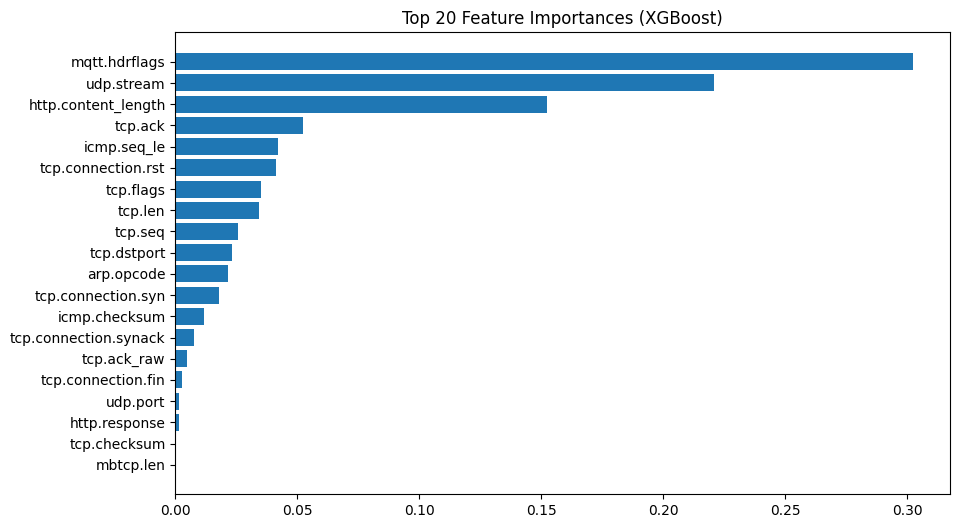


Model file size: 3.13 MB


In [16]:
# Load saved XGBoost model
clf_xgb = joblib.load("xgb_cw_42f_LLf.pkl")

# --- 1) Feature Importances ---
xgb_importances = clf_xgb.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": X_train_clean.columns,    # use same feature order from training
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

feat_imp_df["Normalized"] = feat_imp_df["Importance"] / feat_imp_df["Importance"].sum()

print("\nTop 20 features by importance:")
print(feat_imp_df.head(20))

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df["Feature"].head(20), feat_imp_df["Normalized"].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

# --- 2) Check model file size ---
file_path = "xgb_cw_42f_LLf.pkl"
file_size_MB = os.path.getsize(file_path) / (1024 * 1024)
print(f"\nModel file size: {file_size_MB:.2f} MB")


## 20 Feature XGBoost

In [ ]:
# --- Get Top 20 feature names ---
top20_features = feat_imp_df["Feature"].head(20).tolist()
print("Top 20 Features:", top20_features)

# --- Create reduced train/test sets ---
X_train_20 = X_train[top20_features]
X_test_20 = X_test[top20_features]

# --- Retrain XGBoost ---
xgb_cw_20f = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    tree_method='gpu_hist' if use_gpu else 'hist',
    predictor='gpu_predictor' if use_gpu else 'auto',
    random_state=42
)

xgb_cw_20f.fit(X_train_20, y_train)

# --- Save model ---
joblib.dump(xgb_cw_20f, "xgb_cw_20f.pkl")

# --- Report size ---
size_mb = os.path.getsize("xgb_cw_20f.pkl") / (1024*1024)
print(f"Saved xgb_cw_20f.pkl — size: {size_mb:.2f} MB")

# --- Evaluate quickly ---
y_pred_20 = xgb_cw_20f.predict(X_test_20)
print(classification_report(y_test, y_pred_20, target_names=class_names))

In [19]:
xgb_cw_20f.save_model("xgb_cw_20f.json") 

## Top 10 Feature

In [20]:
# --- Get Top 10 feature names ---
top10_features = feat_imp_df["Feature"].head(10).tolist()
print("Top 10 Features:", top10_features)

# --- Create reduced train/test sets ---
X_train_10 = X_train[top10_features]
X_test_10  = X_test[top10_features]

# --- Retrain XGBoost ---
xgb_cw_10f = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    tree_method='gpu_hist' if use_gpu else 'hist',
    predictor='gpu_predictor' if use_gpu else 'auto',
    random_state=42
)

xgb_cw_10f.fit(X_train_10, y_train)

# --- Save model ---
joblib.dump(xgb_cw_10f, "xgb_cw_10f.pkl")

# --- Report size ---
size_mb = os.path.getsize("xgb_cw_10f.pkl") / (1024*1024)
print(f"Saved xgb_cw_10f.pkl — size: {size_mb:.2f} MB")

# --- Evaluate quickly ---
y_pred_10 = xgb_cw_10f.predict(X_test_10)
print(classification_report(y_test, y_pred_10, target_names=class_names))


Top 10 Features: ['mqtt.hdrflags', 'udp.stream', 'http.content_length', 'tcp.ack', 'icmp.seq_le', 'tcp.connection.rst', 'tcp.flags', 'tcp.len', 'tcp.seq', 'tcp.dstport']


/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/aftab/Thesis/thesis-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:33:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved xgb_cw_10f.pkl — size: 2.46 MB
                       precision    recall  f1-score   support

             Backdoor       0.97      0.96      0.96      4972
            DDoS_HTTP       0.75      0.92      0.83      9982
            DDoS_ICMP       1.00      1.00      1.00     23287
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       0.99      1.00      1.00     24314
       Fingerprinting       1.00      0.17      0.29       200
                 MITM       1.00      0.32      0.49       243
               Normal       0.99      1.00      1.00    323129
             Password       0.80      0.82      0.81     10031
        Port_Scanning       1.00      0.88      0.94      4513
           Ransomware       0.97      0.77      0.86      2185
        SQL_injection       0.91      0.78      0.84     10241
            Uploading       0.95      0.86      0.90      7527
Vulnerability_scanner       0.99      0.95      0.97     10022
                 

/usr/lib/python3.12/pickle.py:572: UserWarning: [23:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  rv = reduce(self.proto)


In [21]:
xgb_cw_10f.save_model("xgb_cw_10f.json") 